#### 卷积神经网络搭建
    结构：
    一层卷积
    两层全连接网络
    
    卷积：
    5x5 conv, filters=6
    2x2 pool, strides=2
    C（核：6*5*5，步长：1，填充：same ）
    B（Yes）
    A（relu）
    P（max，核：2*2，步长：2，填充：same）
    D（0.2）
    
    全连接层：
    Dense 128
    Dense 10
    
    Flatten
    Dense（神经元：128，激活：relu，Dropout：0.2）
    Dense（神经元：10，激活：softmax）

    

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 58s 1ms/sample - loss: 1.6767 - sparse_categorical_accuracy: 0.3910 - val_loss: 1.4354 - val_sparse_categorical_accuracy: 0.4852
Epoch 2/5
50000/50000 [==============================] - 58s 1ms/sample - loss: 1.4630 - sparse_categorical_accuracy: 0.4708 - val_loss: 1.3987 - val_sparse_categorical_accuracy: 0.4871
Epoch 3/5
50000/50000 [==============================] - 59s 1ms/sample - loss: 1.3890 - sparse_categorical_accuracy: 0.5007 - val_loss: 1.2976 - val_sparse_categorical_accuracy: 0.5282
Epoch 4/5
50000/50000 [==============================] - 67s 1ms/sample - loss: 1.3276 - sparse_categorical_accuracy: 0.5239 - val_loss: 1.2388 - val_sparse_categorical_accuracy: 0.5635
Epoch 5/5
50000/50000 [==============================] - 76s 2ms/sample - loss: 1.2939 - sparse_categorical_accuracy: 0.5355 - val_loss: 1.1922 - val_sparse_categorical_accuracy: 0.5818
Model: "baseline"
__

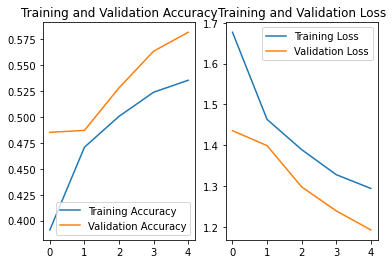

In [1]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras import Model

np.set_printoptions(threshold=np.inf)

cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

##################网络结构##################
class Baseline(Model):
    def __init__(self):
        super(Baseline, self).__init__()
        self.c1 = Conv2D(filters=6, kernel_size=(5, 5), padding='same')  # 卷积层
        self.b1 = BatchNormalization()  # BN层
        self.a1 = Activation('relu')  # 激活层
        self.p1 = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')  # 池化层
        self.d1 = Dropout(0.2)  # dropout层

        self.flatten = Flatten()
        self.f1 = Dense(128, activation='relu')
        self.d2 = Dropout(0.2)
        self.f2 = Dense(10, activation='softmax')

    def call(self, x):
        x = self.c1(x)
        x = self.b1(x)
        x = self.a1(x)
        x = self.p1(x)
        x = self.d1(x)

        x = self.flatten(x)
        x = self.f1(x)
        x = self.d2(x)
        y = self.f2(x)
        return y
##########################################

model = Baseline()

#compile配置训练方法
model.compile(optimizer='adam',#优化器Adam
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#损失函数from_logits=False  f2 = Dense(10, activation='softmax')
              metrics=['sparse_categorical_accuracy'])#评测指标

checkpoint_save_path = "./checkpoint/Baseline.ckpt"
if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    model.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True)
#fit执行训练过程
history = model.fit(x_train, y_train, 
                    batch_size=32,
                    epochs=5, 
                    validation_data=(x_test, y_test), 
                    validation_freq=1,#多少次数据集迭代用测试集验证准确率
                    callbacks=[cp_callback])#使用回调函数实现断点续训
model.summary()

# print(model.trainable_variables)
file = open('./weights.txt', 'w')
for v in model.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()

###############################################    show   ###############################################

# 显示训练集和验证集的acc和loss曲线
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
